# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100


ModuleNotFoundError: No module named 'mendeleev'


# Function that sets up HNC QSP 

### Create and run plasma

In [3]:
name='H'
Z, A = 1,1
mi = m_p * A

ni_cc = 5.98e23
ri_cm = rs_from_n(ni_cc)
ri_AU = ri_cm*cm_to_AU


### Make βu_ii, βu_fi from using bound density from AA
If we assume the bound state does not deform at all, then we can calculate potentials based on it easily via integration

### Solving

In [4]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

def custom_flat(hnc_matrix):
    hnc_flat = np.concatenate([hnc_matrix[0,0],hnc_matrix[0,1],hnc_matrix[1,1]])
    return hnc_flat

def custom_unflat(hnc_flat):
    hnc00, hnc01, hnc11 = np.split(hnc_flat,3)
    hnc_matrix = np.zeros((2,2,len(hnc00)))
    hnc_matrix[0,0] = hnc00
    hnc_matrix[1,0] = hnc01
    hnc_matrix[0,1] = hnc01
    hnc_matrix[1,1] = hnc11
    return hnc_matrix

def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None, ftol=1e-8):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    get_sparse_csk = lambda c_s_k_flat: np.concatenate([interp1d(plasma.hnc.k_array, c_s_k)(sparse_k_array) for c_s_k in np.split(c_s_k_flat,3) ])
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='cubic')(plasma.hnc.k_array)
    get_csk_matrix_from_sparse_csk_flat =  lambda sparse_c_s_k_flat: custom_unflat(np.concatenate([get_csk(sparse_csk) for sparse_csk in np.split(sparse_c_s_k_flat,3)]))
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sparse_c_s_k_flat)
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.hnc.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = custom_flat(new_c_s_k_matrix)
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = custom_flat(c_s_k_guess)
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    plasma.hnc.c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sol.x)
    plasma.hnc.set_all_matrices_from_csk(plasma.hnc.c_s_k_matrix)
    print(sol)

def best_shift(plasma, c_s_k_guess = None, ftol=1e-8, set=True):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    def min_function(multiplier_list):
        xii, xei, xee = multiplier_list
        multiplier_matrix = np.array([[xii,xei],[xei,xee]])
        c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * c_s_k_guess
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        
        return c_s_k_matrix.flatten() - new_c_s_k_matrix.flatten()
    
    sol = least_squares(min_function, np.ones((3)) , verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    xii, xei, xee = sol.x
    multiplier_matrix = np.array([[xii,xei],[xei,xee]])
    
    plasma.hnc.c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * c_s_k_guess
    print(sol)
    return sol

In [5]:
def plasma_f(T_eV, Rc, Zbar, closure='svt'):
    plasma = PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options = {'Te_c_type':'DMC'},
             hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':closure},
             hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
             root_options={'options':{'maxfev':100,'xtol':1e-14}})

    return plasma

In [6]:
def ocp_f(T_eV, Zbar):
    ocp = PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
    ocp.run_ocp_hnc()
    return ocp

def yp_f(T_eV, Zbar):
    yukawa_plasma =  PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
    yukawa_plasma.run_yukawa_hnc();
    return yukawa_plasma

In [7]:
def save_plasma(plasma, Rc):
    T_eV = plasma.Ti_eV
    Zbar = plasma.qsp.Zbar
    ocp = ocp_f( T_eV, Zbar)
    yp  = yp_f(T_eV, Zbar )
    
    # Make header
    info_header = (f"# Zach Johnson Dec/11/2023 CHNC for TCCW Paper" + '\n' + 
                   f"# Ti={T_eV:0.3e}[eV], Tie={plasma.qsp.Tie_c*AU_to_eV:0.3e}[eV] , Te_c={plasma.qsp.Te_c*AU_to_eV:0.3e}[eV], n_i={plasma.ni_cc:0.3e}[1/cc], n_e={Zbar*plasma.ni_cc:0.3e}[1/cc]" + '\n' + 
                   f"# ri={ri_AU:0.3f}, Zbar={Zbar:0.3f}, Rc={Rc:0.3f}[AU], Γii={plasma.qsp.Γii:0.3e}, Γei={plasma.qsp.Γei:0.3e} , Γee={plasma.qsp.Γee:0.3e}, κ={plasma.qsp.get_κ():0.3e}" 
                  )
    column_header = f"{'r/ri':10}  {'g_ii':10}  {'g_ei':10}  {'g_ee':10}  {'OCP:g_ii':10}  {'Yuk:g_ii':10}  {'βu_ii_eff':10}  {'βu_OCP':10}  {'βu_Yuk':10}"
    header = info_header + '\n' + column_header
    
    # Make save array
    save_array = np.array([  plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1, plasma.hnc.h_r_matrix[0,1]+1, plasma.hnc.h_r_matrix[1,1]+1,
                           ocp.ocp_hnc.h_r_matrix[0,0]+1, yp.yuk_hnc.h_r_matrix[0,0] + 1, plasma.hnc.βueff_r_matrix_with_B[0,0],
                           ocp.ocp_hnc.βu_r_matrix[0,0], yp.yuk_hnc.βu_r_matrix[0,0]]).T
    
    np.savetxt(f"/home/zach/plasma/hnc/TCCW/Final_TCCW/results/CHNC_H_rs{ri_AU:0.3f}_TeV{plasma.Ti_eV:0.3f}.dat", save_array, 
               header=header, fmt='%10.5e', comments='')

### Now Load Data from George
Rc is interpreted as the average bound radius, in AU in the file. Empty-core Ashcroft assumed.

In [8]:
GP_data   = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/GP_data/H_combined.dat", header=0, delim_whitespace=True)
T_eV_list = GP_data['Te(eV)']
Rc_list   = GP_data['Rc'] # AU
Zbar_list = GP_data['Z_bar'] #Average atom Zbar GP_data
GP_data

,Te(eV),rho/rho0,Ne_b,Ne_quasi,Ne_sc,Z_bar,Rc,mu,nu_mom,nu_tot,sigma,k_th,L,G
0,0.1,1.0,0.0,0.0,1.0,1.0,0,0.60830,0.112600,0.44460,0.3495,0.004226,3.290,1.235000e-05
1,0.2,1.0,0.0,0.0,1.0,1.0,0,0.60960,0.111800,0.44000,0.3526,0.008530,3.291,1.231000e-05
2,0.5,1.0,0.0,0.0,1.0,1.0,0,0.61320,0.109700,0.42720,0.3618,0.021930,3.298,1.221000e-05
3,1.0,1.0,0.0,0.0,1.0,1.0,0,0.61840,0.106800,0.40890,0.3765,0.045970,3.323,1.207000e-05
4,2.0,1.0,0.0,0.0,1.0,1.0,0,0.62610,0.102800,0.38020,0.4044,0.101200,3.404,1.190000e-05
5,5.0,1.0,0.0,0.0,1.0,1.0,0,0.62760,0.099500,0.32790,0.4783,0.311000,3.539,1.198000e-05
6,10.0,1.0,0.0,0.0,1.0,1.0,0,0.54060,0.101800,0.28640,0.5767,0.821000,3.874,1.215000e-05
7,20.0,1.0,0.0,0.0,1.0,1.0,0,0.09214,0.103100,0.24640,0.8232,2.499000,4.130,1.116000e-05
8,50.0,1.0,0.0,0.0,1.0,1.0,0,-2.42900,0.088140,0.19200,1.9690,13.760000,3.803,7.608000e-06
9,100.0,1.0,0.0,0.0,1.0,1.0,0,-8.66900,0.063270,0.14550,4.4600,61.560000,3.756,4.457000e-06


In [9]:
plasma_list = []

for T_eV, Rc, Zbar in zip(T_eV_list, Rc_list, Zbar_list):
    plasma = plasma_f(T_eV, Rc/ri_AU, Zbar )
    plasma_list.append(plasma)

Te_in_eV: 0.100
Ti_in_eV: 0.100
Te_in_eV: 0.200
Ti_in_eV: 0.200
Te_in_eV: 0.500
Ti_in_eV: 0.500
Te_in_eV: 1.000
Ti_in_eV: 1.000
Te_in_eV: 2.000
Ti_in_eV: 2.000
Te_in_eV: 5.000
Ti_in_eV: 5.000
Te_in_eV: 10.000
Ti_in_eV: 10.000
Te_in_eV: 20.000
Ti_in_eV: 20.000
Te_in_eV: 50.000
Ti_in_eV: 50.000
Te_in_eV: 100.000
Ti_in_eV: 100.000
Te_in_eV: 200.000
Ti_in_eV: 200.000
Te_in_eV: 500.000
Ti_in_eV: 500.000
Te_in_eV: 1000.000
Ti_in_eV: 1000.000
Te_in_eV: 2000.000
Ti_in_eV: 2000.000


In [22]:
guess_c_s_k_matrix = None
for Rc, plasma in zip(Rc_list[::-1], plasma_list[::-1]): 
    # if T_eV == 2.0:
    plasma.run_hnc(c_s_k_guess = guess_c_s_k_matrix)
    if plasma.hnc.tot_err_list[-1] > 1e-7:
        best_shift(plasma)
        solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=200))
        solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=400))
        save_plasma(plasma, Rc)
    else:
        save_plasma(plasma, Rc)
    # guess_c_s_k_matrix = plasma.hnc.c_s_k_matrix.copy()

0: Initial condition Total Error: 2.008e-02
Exiting status 0, reverting to best index so far: 138
Final iter:139, Total Error: 9.747e-09
Te_in_eV: 2000.000
Ti_in_eV: 2000.000
0: Initial condition Total Error: 2.133e-02
Exiting status 0, reverting to best index so far: 139
Final iter:140, Total Error: 9.312e-09
Te_in_eV: 2000.000
Ti_in_eV: 2000.000
0: Initial condition Total Error: 1.175e-02
Exiting status 0, reverting to best index so far: 133
Final iter:134, Total Error: 9.650e-09
0: Initial condition Total Error: 2.737e-02
Exiting status 0, reverting to best index so far: 141
Final iter:142, Total Error: 9.691e-09
Te_in_eV: 1000.000
Ti_in_eV: 1000.000
0: Initial condition Total Error: 2.978e-02
Exiting status 0, reverting to best index so far: 142
Final iter:143, Total Error: 9.491e-09
Te_in_eV: 1000.000
Ti_in_eV: 1000.000
0: Initial condition Total Error: 3.690e-02
Exiting status 0, reverting to best index so far: 144
Final iter:145, Total Error: 9.515e-09
0: Initial condition Total


KeyboardInterrupt



### Plot and Comparison to QMD

In [37]:

# for plasma, Rc in zip(plasma_list[4:5], Rc_list[4:5]):    
#     save_plasma(plasma, Rc)

# Hydrogen

In [10]:
T_eV_list[4], plasma_list[4]

(2.0, <hnc.hnc.PIE.Plasma_of_Ions_and_Electrons at 0x7f059879c6a0>)

In [11]:
H1_GP = read_csv("GP_data/GP_H1_profile.dat", delim_whitespace=True, header=0)
H1_GP

,x,r,Vcoul,Vexc,V,rV,dNedr_b,dNedr_s,dNedr_f,dNedr,ne_b,ne_s,ne_f,ne
0,0.000717,0.001000,1.000000e+03,-0.284900,9.997000e+02,9.997000e-01,0.0,0.000000,0.000036,0.000000,0.0,0.00000,2.85300,0.00000
1,0.000722,0.001007,9.915000e+02,0.265600,9.917000e+02,9.990000e-01,0.0,0.000005,0.000036,0.000005,0.0,0.42100,2.84200,0.42100
2,0.000727,0.001015,9.843000e+02,0.265600,9.846000e+02,9.989000e-01,0.0,0.000005,0.000037,0.000005,0.0,0.42100,2.83200,0.42100
3,0.000732,0.001022,9.772000e+02,0.265600,9.775000e+02,9.989000e-01,0.0,0.000006,0.000037,0.000006,0.0,0.42100,2.82100,0.42100
4,0.000738,0.001029,9.701000e+02,0.265600,9.704000e+02,9.989000e-01,0.0,0.000006,0.000037,0.000006,0.0,0.42100,2.81100,0.42100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.971450,1.355400,6.028000e-04,0.002494,3.095000e-03,4.195000e-03,0.0,1.383000,1.120000,1.383000,0.0,0.05992,0.04851,0.05992
997,0.978510,1.365300,3.391000e-04,0.001858,2.196000e-03,2.998000e-03,0.0,1.394000,1.134000,1.394000,0.0,0.05952,0.04841,0.05952
998,0.985620,1.375200,1.508000e-04,0.001231,1.381000e-03,1.899000e-03,0.0,1.405000,1.148000,1.405000,0.0,0.05913,0.04832,0.05913
999,0.992790,1.385200,3.771000e-05,0.000611,6.486000e-04,8.984000e-04,0.0,1.417000,1.163000,1.417000,0.0,0.05875,0.04823,0.05875


In [12]:
H1_CHNC = read_csv("results/CHNC_H_rs1.391_TeV2.000.dat", delim_whitespace=True, header=3)
H1_ri = 1.391
H1_Zbar = 1
H1_ne0 = H1_Zbar/(4/3*np.pi*H1_ri**3)
H1_CHNC

,r/ri,g_ii,g_ei,g_ee,OCP:g_ii,Yuk:g_ii,βu_ii_eff,βu_OCP,βu_Yuk
0,0.01,0.0,4.11571,0.134987,0.0,0.0,9.667310e+02,978.062000,9.590460e+02
1,0.02,0.0,4.00360,0.137239,0.0,0.0,4.778560e+02,489.185000,4.703480e+02
2,0.03,0.0,3.89509,0.139769,0.0,0.0,3.149000e+02,326.226000,3.075660e+02
3,0.04,0.0,3.79009,0.142586,0.0,0.0,2.334250e+02,244.746000,2.262610e+02
4,0.05,0.0,3.68850,0.145696,0.0,0.0,1.845420e+02,195.858000,1.775450e+02
...,...,...,...,...,...,...,...,...,...
995,9.96,1.0,1.00000,1.000000,1.0,1.0,-7.191460e-11,0.981681,4.319520e-09
996,9.97,1.0,1.00000,1.000000,1.0,1.0,-7.163140e-11,0.980696,4.232620e-09
997,9.98,1.0,1.00000,1.000000,1.0,1.0,-7.140940e-11,0.979713,4.147480e-09
998,9.99,1.0,1.00000,1.000000,1.0,1.0,-7.124770e-11,0.978733,4.064050e-09


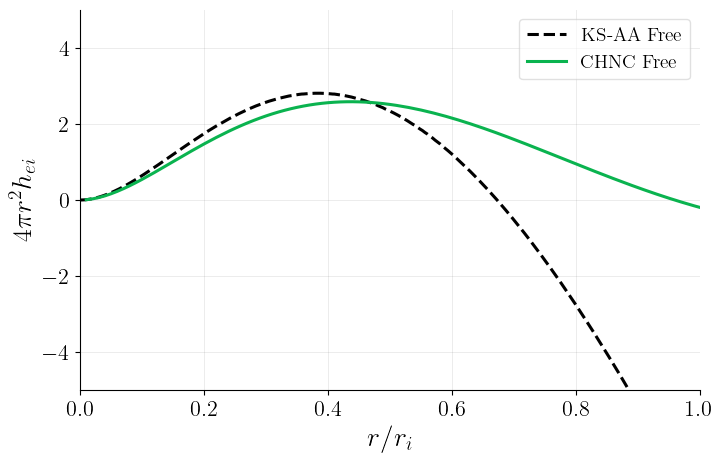

In [13]:
def g_ei_plot(ax):
    ax.plot(H1_GP['x'], (H1_GP['ne_s']/H1_ne0-1)*4*π*(H1_GP['r'])**2,'k--', label="KS-AA Free"  )
    ax.plot(H1_CHNC['r/ri'],(H1_CHNC['g_ei']-1)*4*π*(H1_CHNC['r/ri']*H1_ri)**2, label="CHNC Free"  )

    ax.set_xlim(0,1)
    ax.set_ylim(-5,5)
    ax.set_ylabel(r"$4\pi r^2 h_{ei}$")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()

fig, ax  = plt.subplots()
g_ei_plot(ax)

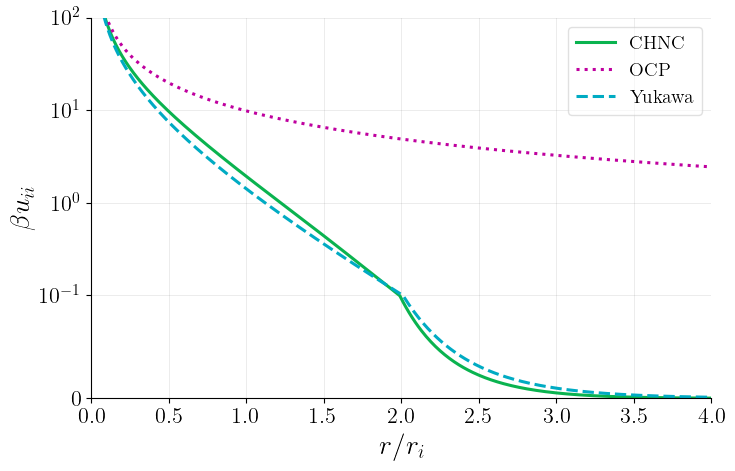

In [14]:
def βu_ii_eff_plot(ax):

    ax.plot(H1_CHNC['r/ri'],H1_CHNC['βu_ii_eff'], label="CHNC"  )
    ax.plot(H1_CHNC['r/ri'],H1_CHNC['βu_OCP'],':', label="OCP"  )
    ax.plot(H1_CHNC['r/ri'],H1_CHNC['βu_Yuk'],'--', label="Yukawa"  )


    ax.set_xlim(0,4)
    ax.set_ylim(0,1e2)
    ax.set_yscale('symlog', linthresh=0.1)
    ax.set_ylabel(r"$\beta u_{ii}$")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()
    
fig, ax  = plt.subplots()
βu_ii_eff_plot(ax)

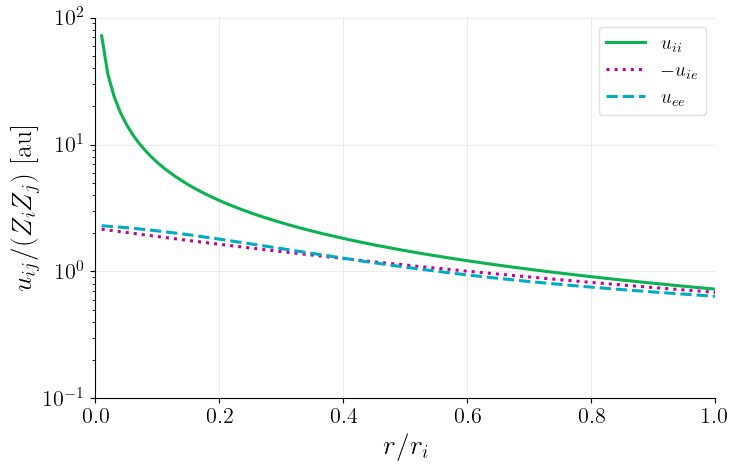

In [17]:
plasma = plasma_list[4]
def βu_ii_plot(ax):
    ax.plot(H1_CHNC['r/ri'], plasma.qsp.Ti*plasma.hnc.βu_r_matrix[0,0], label=r"$u_{ii}$"  )
    ax.plot(H1_CHNC['r/ri'],-plasma.qsp.Tie_c*plasma.hnc.βu_r_matrix[0,1],':', label=r"$-u_{ie}$"  )
    ax.plot(H1_CHNC['r/ri'], plasma.qsp.Te_c*plasma.hnc.βu_r_matrix[1,1],'--', label=r"$u_{ee}$"  )

    ax.set_xlim(0,1)
    ax.set_ylim(1e-1,1e2)
    ax.set_yscale('log')
    ax.set_ylabel(r"$u_{ij}/(Z_i Z_j)$ [au]")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()
    
fig, ax  = plt.subplots()
βu_ii_plot(ax)

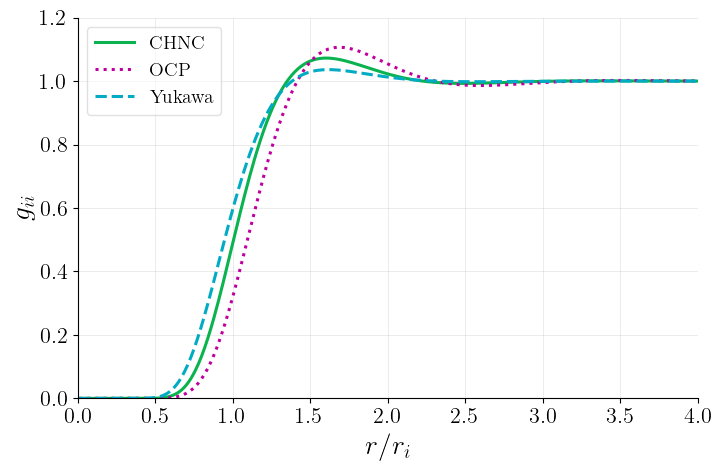

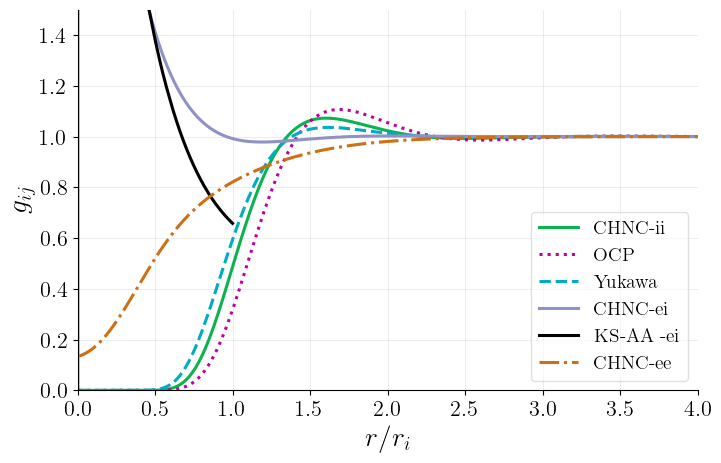

In [18]:
def g_ii_plot(ax):
    ax.plot(H1_CHNC['r/ri'],H1_CHNC['g_ii'], label="CHNC"  )
    ax.plot(H1_CHNC['r/ri'],H1_CHNC['OCP:g_ii'],':', label="OCP"  )
    ax.plot(H1_CHNC['r/ri'],H1_CHNC['Yuk:g_ii'],'--', label="Yukawa"  )


    ax.set_xlim(0,4)
    ax.set_ylim(0,1.2)
    # ax.set_yscale('symlog', linthresh=0.1)
    ax.set_ylabel(r"$g_{ii}$")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()

fig, ax  = plt.subplots( figsize=(8, 4.9443))
g_ii_plot(ax)

def g_ij_plot(ax):
    ax.plot(H1_CHNC['r/ri'],H1_CHNC['g_ii'], label="CHNC-ii"  )
    ax.plot(H1_CHNC['r/ri'],H1_CHNC['OCP:g_ii'],':', label="OCP"  )
    ax.plot(H1_CHNC['r/ri'],H1_CHNC['Yuk:g_ii'],'--', label="Yukawa"  )

    ax.plot(H1_CHNC['r/ri'],H1_CHNC['g_ei'], label="CHNC-ei"  )
    ax.plot(H1_GP['x'], (H1_GP['ne_s']/H1_ne0), 'k-', label="KS-AA -ei "  )

    ax.plot(H1_CHNC['r/ri'],H1_CHNC['g_ee'],'-.', label="CHNC-ee"  )

    ax.set_xlim(0,4)
    ax.set_ylim(0,1.5)
    # ax.set_yscale('symlog', linthresh=0.1)
    ax.set_ylabel(r"$g_{ij}$")
    ax.set_xlabel(r"$r/r_i$")
    ax.legend()

fig, ax  = plt.subplots( figsize=(8, 4.9443))
g_ij_plot(ax)

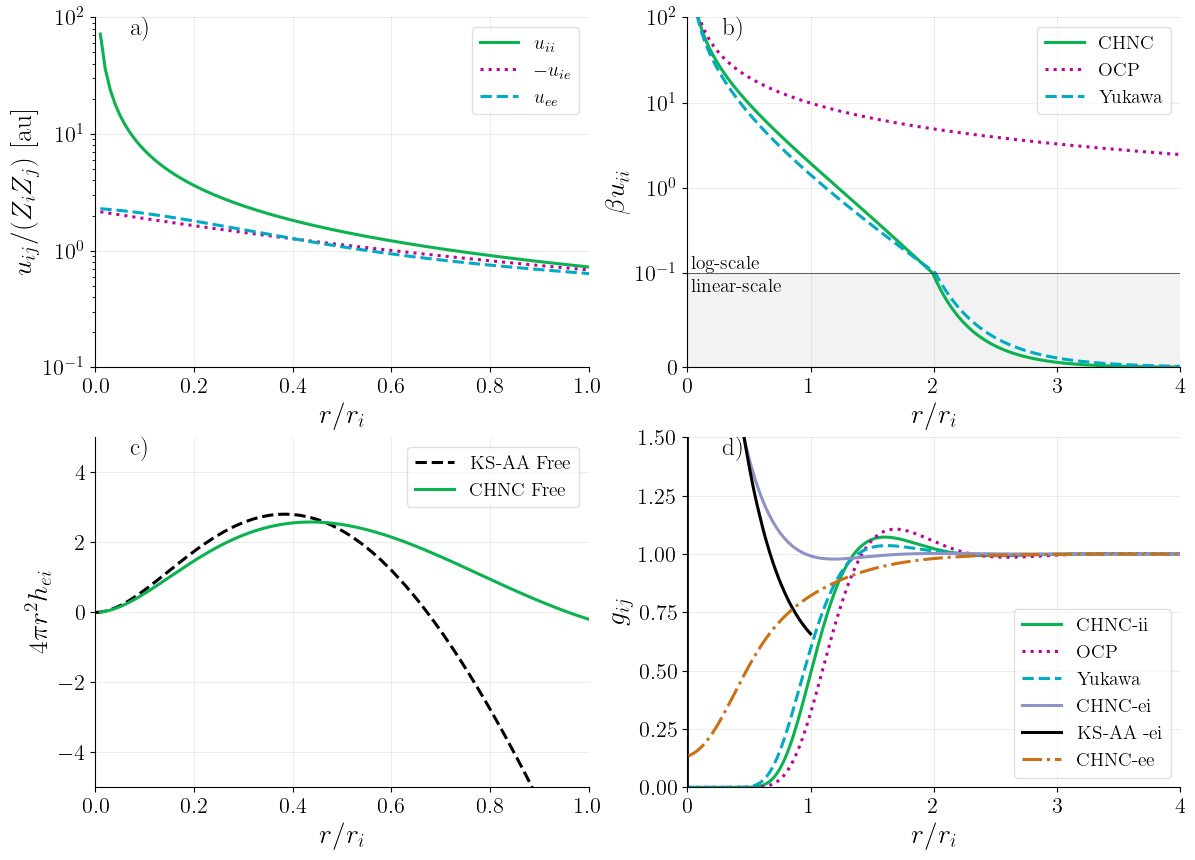

In [19]:
fig, axs = plt.subplots(2,2, figsize=(14, 10))

βu_ii_plot(axs[0,0])
βu_ii_eff_plot(axs[0,1])
g_ei_plot(axs[1,0])
g_ij_plot(axs[1,1])
axs[0,1].axhline(y=0.1,color='k',linewidth=0.4)
axs[0,1].fill_between(np.linspace(0,10),-1,0.1,color='k',alpha=0.05)
axs[0,1].text(0.03, 0.11, "log-scale",fontsize=14)
axs[0,1].text(0.03, 0.08, "linear-scale",fontsize=14)
# Subfigure Labels
axs[0,0].text(0.07, 0.95, "a)", transform=axs[0,0].transAxes, fontsize=18)
axs[0,1].text(0.07, 0.95, "b)", transform=axs[0,1].transAxes, fontsize=18)
axs[1,0].text(0.07, 0.95, "c)", transform=axs[1,0].transAxes, fontsize=18)
axs[1,1].text(0.07, 0.95, "d)", transform=axs[1,1].transAxes, fontsize=18)
plt.savefig("H1_gβu_plot.png", dpi=400)
